# Mamba simplified explanation: practice

Author: Pavel Nakaznenko

### DISCLAIMER:

In this notebook, the solutions presented are not the most efficient or elegantly written, as my primary goal was to demonstrate clarity.
I've tried to structure the code in a step-by-step manner, from the top down, from the general to the specific.
For instance, I didn't introduce a dataclass for model arguments, and I had to make classes arguments that are not yet defined.
In a production environment, you can (and should) make the code more elegant and optimal. For reference, see the [original implementation](https://github.com/state-spaces/mamba) and the [minimalist version](https://github.com/johnma2006/mamba-minimal).
In short, please don't judge too harshly.

In [ ]:
!pip install wandb tqdm matplotlib

# Part 1. Implementing Mamba

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

We'll be writing the [Mamba](https://arxiv.org/ftp/arxiv/papers/2312/2312.00752.pdf) model "from top to bottom."

The process will start by defining the overall architecture and key components, then move towards more specific details and functionalities. This top-down approach helps in understanding the flow and integration of different parts of the model, leading to a more organized and understandable code structure.

Let's begin by setting up the basic structure and gradually filling the details.
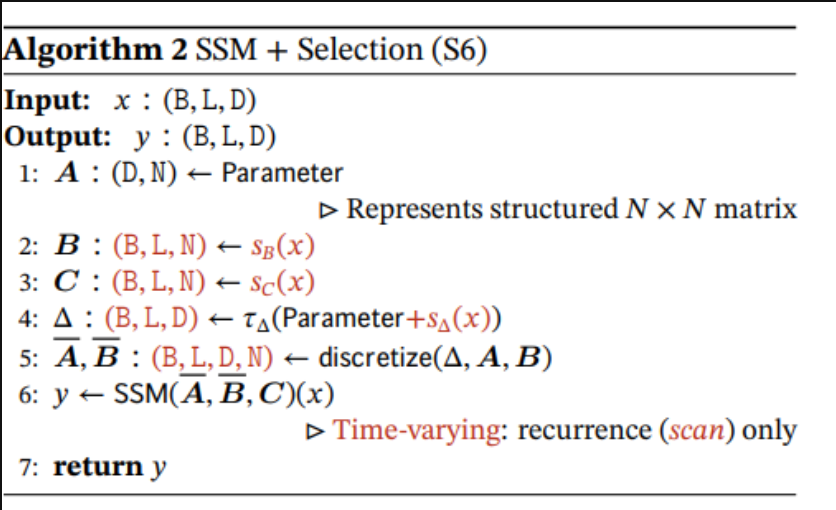

The coefficient _E_ is the expansion factor for the hidden state dimensionality. It's used to increase the model's dimensionality, allowing for the expansion of the model's hidden states. This potentially improves the model's ability to learn and represent complex patterns in data.

_R_ is a hyperparameter for reparameterization, which facilitates the transition from a dimensionality of 1 to a dimensionality of R:

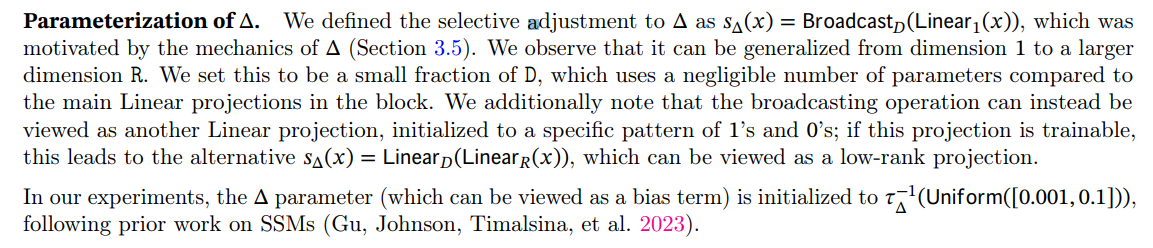

Additionally, we'll define the Mamba class and subsequently implement each of its components.

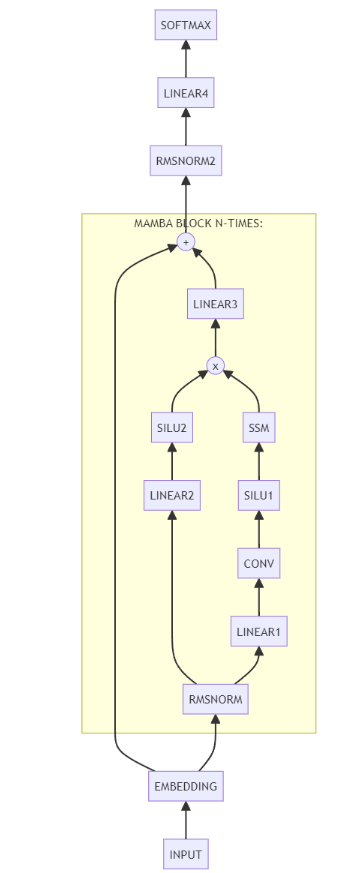

As we proceed, we'll focus on implementing and integrating each of these components, ensuring that they work harmoniously within the overall structure of the Mamba model.

In [2]:
class Mamba(nn.Module):
    def __init__(self,
                        hidden_dim: int, # dimensionality of the hidden representation
                        num_layers: int, # number of layers
                        vocab_size: int, # size of the vocabulary
                        normalization_cls = None, # the class that will be used for normalization. Later this will be RMSNorm
                        layer_cls = None, # the class that will be used as a layer. Later this will be ResidualBlock
                        pad_vocab_size_multiple: int = 8, # the vocabulary size should be a multiple of this
):
        super().__init__()
        # make the vocabulary size a multiple of pad_vocab_size_multiple
        self.vocab_size = math.ceil(vocab_size / pad_vocab_size_multiple) * pad_vocab_size_multiple        

        self.norm = normalization_cls(hidden_dim)
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.mamba_layers = nn.ModuleList([layer_cls(hidden_dim) for _ in range(num_layers)])

        self.lm_head = nn.Linear(hidden_dim, vocab_size, bias=False)
        # linking weights, saving memory, training time, and improving the quality of the representation
        # more details here https://arxiv.org/pdf/1608.05859v3.pdf
        self.lm_head.weight = self.embedding.weight   

    def forward(self, input_ids):
        # get embeddings
        x = self.embedding(input_ids)

        # pass through Mamba layers
        for layer in self.mamba_layers:
            x = layer(x)

        # normalize
        x = self.norm(x)

        # project and get logits
        logits = self.lm_head(x)

        return logits

Now let's implement each block. We'll start with something simple: root mean square norm.

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, hidden_dim, eps=1e-8):
        super(RMSNorm, self).__init__()
        self.hidden_dim = hidden_dim
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(hidden_dim))

    def forward(self, x):
        """ 
        Input is a tensor of shape (batch_size, seq_length, hidden_dim)
        Output is the same tensor, but normalized
        Read about how and why it works here: https://arxiv.org/pdf/1910.07467.pdf
        """
        # calculate root mean square
        rms = torch.sqrt(torch.mean(x**2, dim=-1, keepdim=True) + self.eps)
        # normalize with learnable scale
        x = x / rms * self.scale
        return x

Next, we'll implement the block that supports Residual connections.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim: int, **kwargs):
        """Wrapper for a Mamba block with residual connection and RMSNorm"""
        super().__init__()
        self.mamba = MambaBlock(hidden_dim)
        self.norm = RMSNorm(hidden_dim)
        
    def forward(self, x):
        """
        Input is a tensor of shape (batch_size, seq_length, hidden_dim)
        Output is a tensor of the same size
        """
        # normalize
        output = self.norm(x)

        # pass through Mamba
        output = self.mamba(output)

        # add a residual connection
        output += x

        return output

Now we're getting to the core part: the MambaBlock.

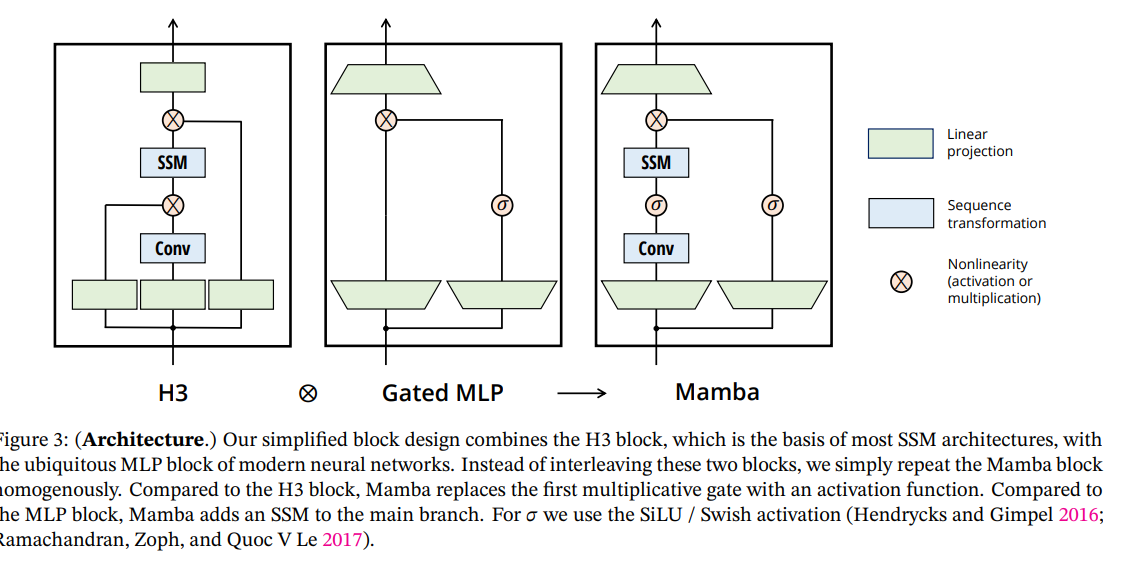

And the SSM (State Space Model) algorithm.

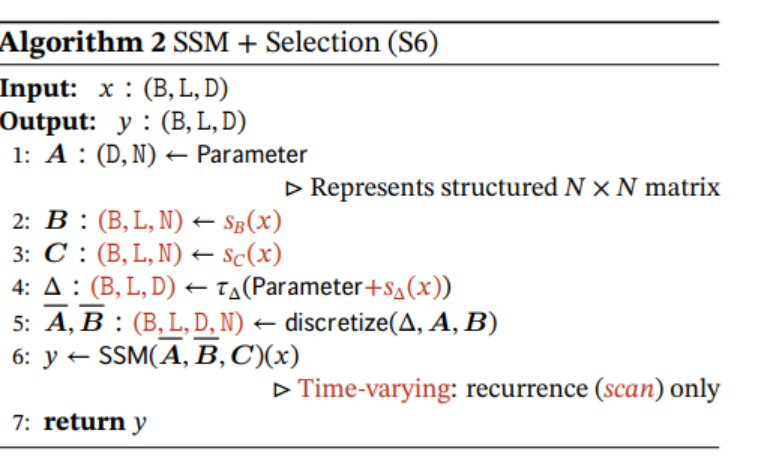

These components are crucial to the functionality of the Mamba model. The MambaBlock is where the main computation and transformation of the input data occur, and the SSM algorithm is integral to handling the state space representation within the model. Implementing these parts requires careful attention to the mathematical operations and the flow of data through the model.

In [5]:
class MambaBlock(nn.Module):
    def __init__(self, 
                        hidden_dim: int, # dimensionality of hidden representation
                        kernel_size: int = 128, # size of the convolutional kernel    
                        latent_state_dim: int = 64, # dimensionality of the latent state
                        E: int = 2, # expansion factor for hidden_dim, see section 3.4 of the paper
                        R: int = 48, # dimensionality for reparameterization, see section 3.6 of the paper    
                        
                        conv_bias: bool = True, # whether bias is needed for convolutional layers
                        proj_bias: bool = False, # whether bias is needed for projection layers
                 ):
        super().__init__()
        
        # expand the dimensionality of hidden representation (this is parameter D in the paper)
        self.hidden_dim_expanded = E * hidden_dim
        self.R = R
        self.latent_state_dim = latent_state_dim
        self.kernel_size = kernel_size
        
        # projection layer inside
        self.in_proj = nn.Linear(hidden_dim, self.hidden_dim_expanded * 2, bias=proj_bias)
        
        # convolutional layer
        self.conv1d = nn.Conv1d(
            in_channels=self.hidden_dim_expanded,
            out_channels=self.hidden_dim_expanded,
            bias=conv_bias,
            kernel_size=kernel_size,
            groups=self.hidden_dim_expanded,
            padding=kernel_size - 1,
        )

        # x_proj projects `x` and yields Δ, B, and C corresponding to the input
        self.x_proj = nn.Linear(self.hidden_dim_expanded, R + latent_state_dim * 2, bias=False)
        
        # dt_proj projects Δ from R to hidden_dim_expanded
        self.dt_proj = nn.Linear(R, self.hidden_dim_expanded, bias=True)

        # create a 1D tensor with values from 1 to latent_state_dim
        sequence = torch.arange(1, latent_state_dim + 1)
        # convert the sequence into a 2D tensor with hidden_dim_expanded rows of repetitions
        A = sequence.unsqueeze(0).repeat(self.hidden_dim_expanded, 1)
        
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.hidden_dim_expanded))
        self.out_proj = nn.Linear(self.hidden_dim_expanded, hidden_dim, bias=proj_bias)
        

    def forward(self, x):
        """
        Input is a tensor of shape (batch_size, seq_length, hidden_dim)
        Output is a tensor of the same size
        """
        (batch_size, seq_length, hidden_dim) = x.shape

        # project into x and residual parts 
        # (batch_size, seq_length, hidden_dim) -> (batch_size, seq_length, 2 * hidden_dim)
        x_and_residual = self.in_proj(x)
        
        (x, residual) = x_and_residual.split(split_size=[self.hidden_dim_expanded, self.hidden_dim_expanded], dim=-1)

        # swap dimensions of tensors (batch_size, seq_length, hidden_dim_expanded) -> (batch, hidden_dim_expanded, seq_length)
        x = x.permute(0, 2, 1)
        
        # apply convolution and trim to seq_length
        x = self.conv1d(x)[:, :, :seq_length]
        
        # swap dimensions back to the original order
        x = x.permute(0, 2, 1)

        # apply activation function
        x = F.silu(x)

        # apply ssm
        y = self.ssm(x)

        # mix with residual after activation 
        y = y * F.silu(residual)

        # project the output outward (batch_size, seq_length, hidden_dim_expanded) -> (batch_size, seq_length, hidden_dim)
        output = self.out_proj(y)

        return output

    
    def ssm(self, x):
        """
            Input is a tensor of shape (batch_size, seq_length, hidden_dim_expanded)
            Output is a tensor of the same size
        """
        # calculate state space parameters delta, A, B, C, and D
        #     A, D do not depend on input (see 3.5.2 "Interpretation of A" why)
        #     delta, B, C depend on input, which is the novelty of Mamba compared to time invariant S4,
        #                                  and that's why Mamba is called selective state spaces (S6)
        
        A = -torch.exp(self.A_log.float())  # shape (hidden_dim_expanded, latent_state_dim)
        D = self.D.float()

        # project and concatenate delta, B, C
        x_cat = self.x_proj(x)  # (batch_size, seq_length, R + 2*n)

        # split x_cat into
        # delta: (batch_size, seq_length, R)
        # B: (batch_size, seq_length, n)
        # C: (batch_size, seq_length, n)
        (delta, B, C) = x_cat.split(split_size=[self.R, self.latent_state_dim, self.latent_state_dim], dim=-1)  

        # project delta from R to hidden_dim_expanded
        # and activate with softplus
        # (batch_size, seq_length, hidden_dim_expanded)
        delta = F.softplus(self.dt_proj(delta))

        # now perform selective scan
        y = self.selective_scan(x, delta, A, B, C, D)
        
        return y

    
    def selective_scan(self, u, delta, A, B, C, D):
        """Implementation of the selective scan algorithm. See:
            - Section 2 State Space Models
            - Algorithm 2 in Section 3.2
            - run_SSM(A, B, C, u) in The Annotated S4 https://srush.github.io/annotated-s4/

        Classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        with the only difference being that B and C (as well as the step size delta used for discretization) depend on the input x(t).
    
        Inputs:
            u: shape (batch_size, seq_length, hidden_dim_expanded)
            delta: shape (batch_size, seq_length, hidden_dim_expanded)
            A: shape (hidden_dim_expanded, latent_state_dim)
            B: shape (batch_size, seq_length, latent_state_dim)
            C: shape (batch_size, seq_length, latent_state_dim)
            D: shape (hidden_dim_expanded,)
    
        Outputs:
            output: shape (batch_size, seq_length, hidden_dim_expanded)    
        """
        (batch_size, seq_length, hidden_dim_expanded) = u.shape
        
        # discretize continuous parameters A and B
        # - A is discretized using the zero-order hold (ZOH) method (https://en.wikipedia.org/wiki/Zero-order_hold)
        # - B is discretized using a simplified Euler discretization. As per the authors:
        #   "The A parameter is more important and the network works not significantly worse if we simplify the B parameter"
        deltaA = torch.exp(torch.einsum('b l d, d n -> b l d n', delta, A))
    
        # calculate delta * B * u for each time step
        deltaB_u = torch.einsum('b l d, b l n, b l d -> b l d n', delta, B, u)
    
        # initialize states x and a list to store output values y
        x = torch.zeros((batch_size, hidden_dim_expanded, self.latent_state_dim), device=deltaA.device)
        ys = []
    
        # iterate through the entire sequence
        for i in range(seq_length):
            # update state x using current deltaA and deltaB_u values
            x = deltaA[:, i] * x + deltaB_u[:, i]
    
            # compute the output value y at the current time step
            y = torch.einsum('b d n, b n -> b d', x, C[:, i, :])
    
            # add the current y value to the list
            ys.append(y)
    
        # stack all the output values y into one tensor
        y = torch.stack(ys, dim=1)
    
        # add the influence of the input signal u, multiplied by D, to each element of the output tensor y
        y = y + u * D
    
        return y

Phew! Great job, we've covered the key components. Now, let's train it on MNIST dataset to predict the second half of an image based on the first half of an image in an autoregressive manner

# Part 2. Training on MNIST

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb
import numpy as np
import matplotlib.pyplot as plt

In [7]:
SIDE = 14 # image side size in px

In [8]:
# prepare dataset and downsize the images to speedup the training
transform = transforms.Compose([transforms.Resize((SIDE, SIDE)), transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 35233384.87it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 34772618.88it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Let's create our minimalist transformer-decoder with a RoPE encoder for positions. We'll tackle the task of predicting pixels (256 classes) in an autoregressive manner using this transformer and Mamba.

In [9]:
import math

class RoPEPositionalEncoding(nn.Module):
    """
    RoPE encoder for token positions.
    Implementation details can be found here: https://arxiv.org/abs/2104.09864v5
    """
    def __init__(self, d_model, max_len=SIDE*SIDE):
        super(RoPEPositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        pe = self.pe[:seq_len, :].unsqueeze(0)
        return x + pe

class CausalTransformer(nn.Module):
    """
    Classic transformer decoder with causal mask and RoPE.
    """
    def __init__(self, input_size, d_model, nhead, num_layers, num_classes):
        super(CausalTransformer, self).__init__()
        # Token (pixel) embedding layer. 
        # Yes, I understand that this is redundant and absurd, and we could use the pixel values themselves,
        # but here we pretend to solve a toy, tangible problem as if we were predicting text.
        self.embedding = nn.Embedding(input_size, d_model)

        # Token (pixel) positional encoder
        self.pos_encoder = RoPEPositionalEncoding(d_model)

        # Transformer decoder
        transformer_decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_layers)

        # Output head
        self.fc_out = nn.Linear(d_model, num_classes)
        
    def generate_attention_mask(self, sz):
        """
        Generate the causality matrix.
        """
        # Create a matrix of ones and generate a mask for all elements below the main diagonal
        mask = (torch.tril(torch.ones(sz, sz)) == 1)     
        # Build a causal attention mask
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        # Get token (pixel) embeddings
        x = self.embedding(x)

        # Add position to the embeddings
        x = self.pos_encoder(x)

        # Compute the causal attention mask
        tgt_mask = self.generate_attention_mask(x.size(1)).to(x.device)

        # Pass through the transformer layers
        x = self.transformer_decoder(x, x, tgt_mask)

        # Return the result from the output head
        return self.fc_out(x)

In [10]:
# Hyperparameters
hidden_size = 64  # Size of the hidden space
num_layers = 2    # Number of layers
num_heads = 4     # Number of heads (for the transformer)
num_classes = 256 # Dimensionality of our "vocabulary"
learning_rate = 0.0001
num_epochs = 4   # Number of epochs

In [11]:
# Transformer-decoder baseline model
model_transformer = CausalTransformer(num_classes, hidden_size, num_heads, num_layers, num_classes)
criterion_transformer = nn.CrossEntropyLoss()
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=learning_rate)

In [12]:
# Mamba model
model_mamba = Mamba(
    hidden_dim = hidden_size,
    num_layers = num_layers,
    vocab_size = num_classes,
    normalization_cls = RMSNorm,
    layer_cls = ResidualBlock,
    pad_vocab_size_multiple = 8)
criterion_mamba = nn.CrossEntropyLoss()
optimizer_mamba = optim.Adam(model_mamba.parameters(), lr=learning_rate)

In [13]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import OneCycleLR

def train(model, loader, criterion, optimizer, device, run_name):
    wandb.init(project="mnist_pixel_prediction", name=run_name)
    model.train()

    scheduler = OneCycleLR(optimizer, 
                           max_lr = 0.0001,
                           steps_per_epoch = len(loader),
                           epochs = num_epochs,
                           anneal_strategy = 'cos')

    for epoch in tqdm(range(num_epochs), desc="Epoch"):
        pbar = tqdm(loader, desc="Batch")
        for images, _ in pbar:
            images = images.to(device)

            images = images.view(images.size(0), -1, 1)
            targets = images.view(images.size(0), -1)

            # calculate loss for the next predicted pixels
            # by shifting the original pixels by 1
            targets = torch.floor(targets*255).long()[:, 1:]  
            images = torch.floor(images*255).long()[:, :-1, :]

            outputs = model(images.view(images.shape[0], -1))

            y_true = targets.contiguous().view(-1)
            y_pred = outputs.contiguous().view(-1, num_classes)
            
            loss = criterion(y_pred, y_true)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            wandb.log({"loss": loss.item(), "learning_rate": optimizer.param_groups[0]['lr']})
            pbar.set_postfix({"loss": loss.item()})
            
            scheduler.step()
    wandb.finish()

In [14]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Eval batch"):
            images = images.to(device)
            images = images.view(images.size(0), -1, 1)
            targets = images.view(images.size(0), -1)

            # calculate loss for the next predicted pixels
            # by shifting the original pixels by 1
            targets = torch.floor(targets*255).long()[:, 1:]
            images = torch.floor(images*255).long()[:, :-1, :]
            
            outputs = model(images.view(images.shape[0], -1))

            y_true = targets.contiguous().view(-1)
            y_pred = outputs.contiguous().view(-1, num_classes)

            loss = criterion(y_pred, y_true)
            
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [15]:
def visualize_predictions(model, loader, device, num_samples=4):
    """
    A helper function for visualizing predictions based on the first half of pixels.
    """
    model.eval()
    images, _ = next(iter(loader))
    images = images[:num_samples].to(device)
    original_images = images.view(images.size(0), -1, 1)
    predicted_images = torch.zeros_like(original_images)
    predicted_images[:, :original_images.size(1) // 2] = original_images[:, :original_images.size(1) // 2]
    predicted_images = torch.floor(predicted_images*255).long()
    print(f"{original_images.shape=} {predicted_images.shape=}")
    with torch.no_grad():
        for i in range(original_images.size(1) // 2, original_images.size(1)):            
            outputs = model(predicted_images[:, :i].view(predicted_images.shape[0], -1))
            predicted_pixels = outputs[:, i-1].argmax(dim=1)
            predicted_images[:, i] = predicted_pixels.unsqueeze(-1).long()

    original_images = original_images.view(num_samples, SIDE, SIDE).cpu().numpy()
    predicted_images = predicted_images.view(num_samples, SIDE, SIDE).cpu().numpy()

    fig, axs = plt.subplots(2, num_samples, figsize=(10, 4))
    for i in range(num_samples):
        axs[0, i].imshow(original_images[i], cmap='gray')
        axs[1, i].imshow(predicted_images[i], cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mamba = model_mamba.to(device)
model_transformer = model_transformer.to(device)
model_mamba, model_transformer

(Mamba(
   (norm): RMSNorm()
   (embedding): Embedding(256, 64)
   (mamba_layers): ModuleList(
     (0-1): 2 x ResidualBlock(
       (mamba): MambaBlock(
         (in_proj): Linear(in_features=64, out_features=256, bias=False)
         (conv1d): Conv1d(128, 128, kernel_size=(128,), stride=(1,), padding=(127,), groups=128)
         (x_proj): Linear(in_features=128, out_features=176, bias=False)
         (dt_proj): Linear(in_features=48, out_features=128, bias=True)
         (out_proj): Linear(in_features=128, out_features=64, bias=False)
       )
       (norm): RMSNorm()
     )
   )
   (lm_head): Linear(in_features=64, out_features=256, bias=False)
 ),
 CausalTransformer(
   (embedding): Embedding(256, 64)
   (pos_encoder): RoPEPositionalEncoding()
   (transformer_decoder): TransformerDecoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerDecoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=

original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


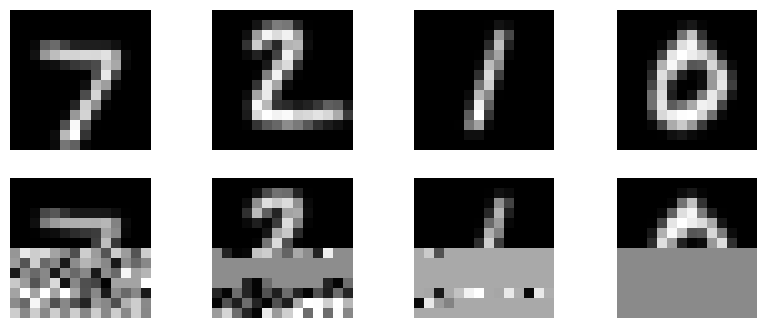

In [17]:
# Let's see how transformer predicts before training
visualize_predictions(model_transformer, test_loader, device)

original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


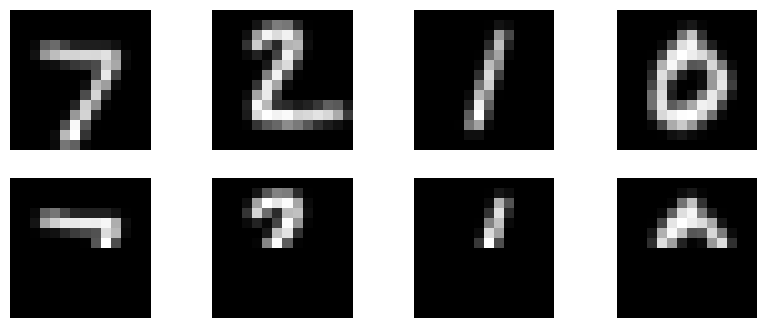

In [18]:
# Let's see how Mamba predicts before training
visualize_predictions(model_mamba, test_loader, device)

In [19]:
# Let's train baseline Transformer model
train(model_transformer, train_loader, criterion_transformer, optimizer_transformer, device, "mnist_transformer")

wandb: Currently logged in as: p-nakaznenko. Use `wandb login --relogin` to force relogin


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

learning_rate,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
loss,█▅▃▄▃▃▃▂▃▃▄▃▃▃▃▃▃▄▂▂▂▁▂▂▃▂▃▃▂▃▂▃▁▃▁▂▂▂▂▁
learning_rate,0.0
loss,1.86499


In [20]:
# Let's train Mamba (it'll take quiet some time)
train(model_mamba, train_loader, criterion_mamba, optimizer_mamba, device, "mnist_mamba")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

Batch:   0%|          | 0/15000 [00:00<?, ?it/s]

learning_rate,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
loss,1.61325


## Results

Transformer's predictions:

Eval batch:   0%|          | 0/2500 [00:00<?, ?it/s]

Transformer Validation Loss: 1.8240324123859406
original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


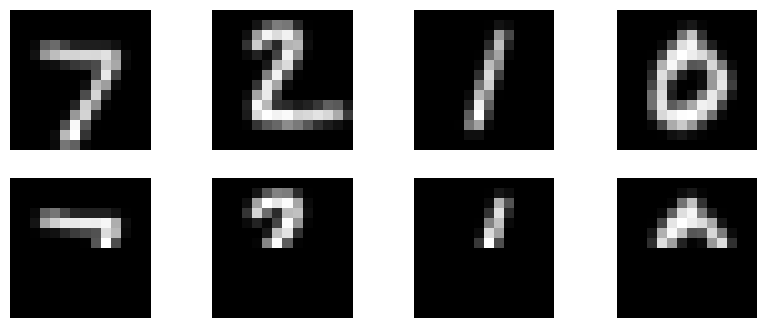

In [21]:
val_loss = evaluate(model_transformer, test_loader, criterion_transformer, device)
print("Transformer Validation Loss:", val_loss)
visualize_predictions(model_transformer, test_loader, device)

Mamba's predictions:

Eval batch:   0%|          | 0/2500 [00:00<?, ?it/s]

Mamba Validation Loss: 1.5655104642391204
original_images.shape=torch.Size([4, 196, 1]) predicted_images.shape=torch.Size([4, 196, 1])


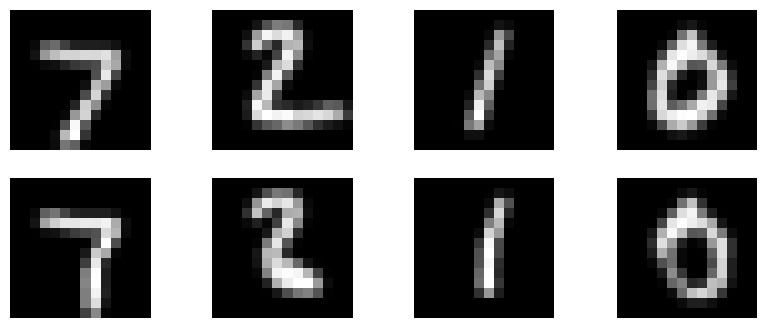

In [22]:
val_loss = evaluate(model_mamba, test_loader, criterion_mamba, device)
print("Mamba Validation Loss:", val_loss)
visualize_predictions(model_mamba, test_loader, device)

Loss plots:

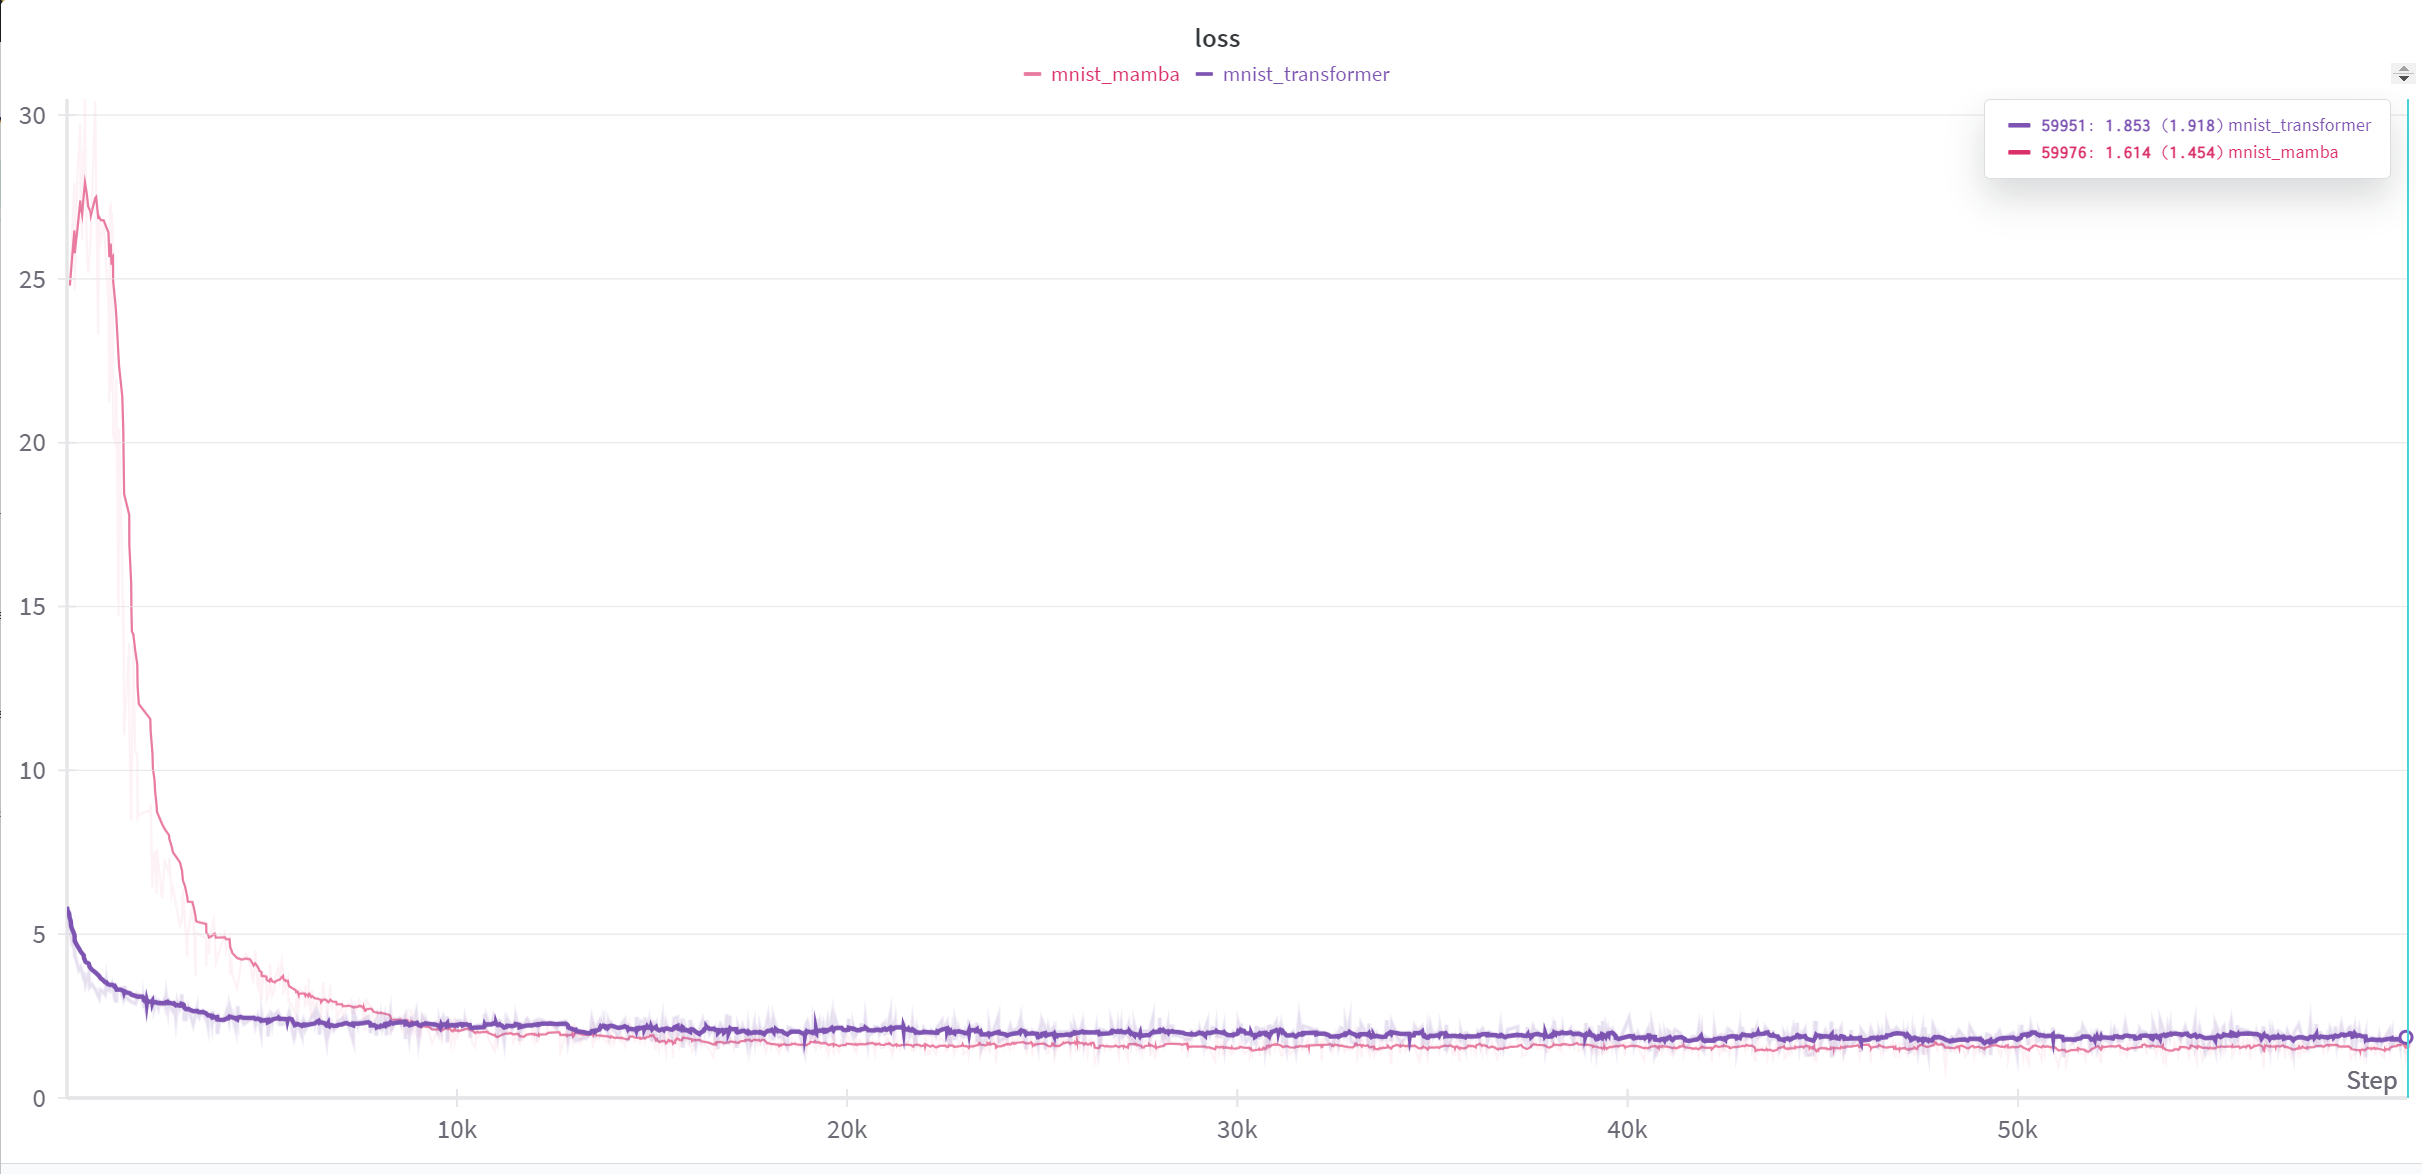

# You are amazing!